In [1]:
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import h5py
import scipy as sc
from scipy import stats
import pandas as pd
%matplotlib inline
import os
import csv
import scipy.stats as stats
from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.api as sm
import statsmodels.formula.api as smf

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def Benjamini_Hochberg_pvalcorrection(vector_of_pvals):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    
    # Returns: Corrected p values.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].size #Total number of hypotheses
    corrected_sortedpvals = np.nan*np.ones((sortedpvals.size,))
    corrected_sortedpvals[m-1] = sortedpvals[m-1]
    for i in range(m-2, -1, -1):
        corrected_sortedpvals[i] = np.amin([corrected_sortedpvals[i+1], sortedpvals[i]*m/(i+1)])
    correctedpvals = np.nan*np.ones((vector_of_pvals.size,))
    correctedpvals[orderofpvals] = corrected_sortedpvals
    return correctedpvals

In [3]:
basedir = r'E:\2p\Analyzeddata_final_direct_exposure\extractedsignals'

epoch_limits = [0, 1500, 3000, 4500] # Frames when experiment switches between baseline to stim and back to baseline
framerate=5

groups = os.walk(basedir).next()[1]

alldata = {}
for group in groups:
    conditions = os.walk(os.path.join(basedir, group)).next()[1]
    conditions = conditions[::-1]
    alldata[group] = {}
    for condition in conditions:
        npyfiles = os.walk(os.path.join(basedir, group, condition)).next()[2]
        animals = [a.split('_')[1] for a in npyfiles]
        alldata[group][condition] = {}
        for npyfile in npyfiles:
            animal = npyfile.split('_')[1]
            alldata[group][condition][animal]=np.squeeze(np.load(os.path.join(basedir,group,condition,npyfile)))-1
            print group, animal, alldata[group][condition][animal].shape

cellbodies OTPVNlens2p1 (23L, 4500L)
cellbodies OTPVNlens2p3 (10L, 4500L)
cellbodies OTPVNlens2p5 (7L, 4500L)
cellbodies OTPVNlens2p4 (8L, 4500L)
cellbodies OTPVNlens2p6 (5L, 4500L)
cellbodies OTPVNlens2p8plane450 (22L, 4500L)
cellbodies OTPVNlens2p9 (17L, 4500L)
cellbodies OTPVNlens2p7 (10L, 4500L)
cellbodies OTPVNlens2p1 (23L, 4500L)
cellbodies OTPVNlens2p3 (10L, 4500L)
cellbodies OTPVNlens2p5 (7L, 4500L)
cellbodies OTPVNlens2p4 (8L, 4500L)
cellbodies OTPVNlens2p6 (5L, 4500L)
cellbodies OTPVNlens2p8plane450 (22L, 4500L)
cellbodies OTPVNlens2p9 (17L, 4500L)
cellbodies OTPVNlens2p7 (10L, 4500L)
dendrites OTPVNlens2p1 (120L, 4500L)
dendrites OTPVNlens2p3 (87L, 4500L)
dendrites OTPVNlens2p5 (62L, 4500L)
dendrites OTPVNlens2p1 (120L, 4500L)
dendrites OTPVNlens2p3 (87L, 4500L)
dendrites OTPVNlens2p5 (62L, 4500L)


In [4]:
print sorted(alldata[groups[0]][condition])

['OTPVNlens2p1', 'OTPVNlens2p3', 'OTPVNlens2p4', 'OTPVNlens2p5', 'OTPVNlens2p6', 'OTPVNlens2p7', 'OTPVNlens2p8plane450', 'OTPVNlens2p9']


In [5]:
def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2

Testing juvstim: cellbodies vs. dendrites
(3.0315764025717202, 0.0029210855985038336)



Testing emptybottle: cellbodies vs. dendrites
(2.3969508644234248, 0.018263434386727458)





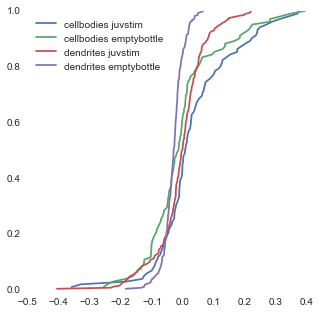

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
mean_responses_dict = {}
for group in groups:
    mean_responses_dict[group] = {}
    for condition in conditions:
        data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
        means = np.mean(data_to_plot[:,epoch_limits[1]:epoch_limits[2]], axis=1)
        baselines = np.mean(data_to_plot[:,epoch_limits[0]:epoch_limits[1]], axis=1)
        mean_responses_dict[group][condition] = means-baselines
        CDFplot(mean_responses_dict[group][condition], ax, label='%s %s'%(group, condition))

ax.legend(loc='upper left')
fig.savefig(os.path.join(basedir, 'CDFs.pdf'), format='pdf')
for condition in conditions:
    print 'Testing %s: %s vs. %s'%(condition, groups[0], groups[1])
    print stats.ttest_ind(mean_responses_dict[groups[0]][condition], mean_responses_dict[groups[1]][condition],
                          equal_var=False)
    print '\n\n'

In [7]:
group = 'cellbodies'

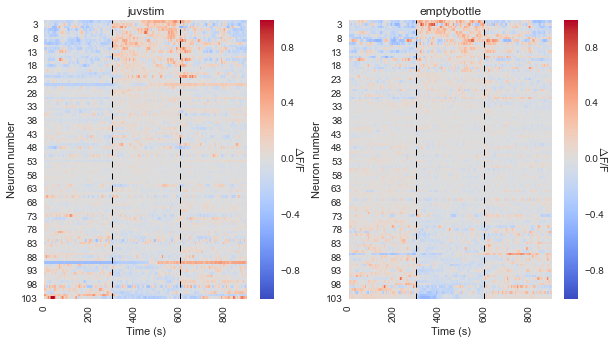

In [8]:
def plot_histograms(signals, epoch_limits, fig, ax, framerate, sort=True,
                    sortedneurons=None, vmin=None, vmax=None, title=''):
    if sort:
        sortedneurons = np.argsort(np.nanmean(signals[:,epoch_limits[1]:epoch_limits[2]], axis=1))[::-1]
    else:
        if sortedneurons is None:
            sortedneurons = np.arange(signals.shape[0])
        else:
            sortedneurons = sortedneurons  
            
    #sns.heatmap(signals[sortedneurons,:], cmap=plt.get_cmap('coolwarm'),
    #            ax=ax, vmin=vmin, vmax=vmax, linewidth=0)
    cax = sns.heatmap(signals[sortedneurons,:], cmap=plt.get_cmap('coolwarm'),
                      ax=ax, vmin=vmin, vmax=vmax, linewidth=0)
    cbar = cax.collections[0].colorbar
    #cbar.set_ticks([-0.2, 0, 0.2])
    #cbar.set_ticklabels(['-0.2', '0', '0.2'])
    cbar.set_label('$\Delta$F/F', rotation='270')#, fontsize='5', labelpad=10)
    
    ax.grid(b=False)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neuron number')
    ax.set_xticks(range(0, epoch_limits[-1]+1, 1000))
    ax.set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[-1]+1, 1000)])
    ax.set_yticks(range(0, signals.shape[0], 5))
    ax.set_yticklabels([str(a+1) for a in range(signals.shape[0],0, -5)])
    ax.plot([epoch_limits[1], epoch_limits[1]], [0, signals.shape[0]], '--k', linewidth=1)
    ax.plot([epoch_limits[2], epoch_limits[2]], [0, signals.shape[0]], '--k', linewidth=1)
    return fig, ax, sortedneurons

def movingaverage(signals, window_size=10):
    results = np.nan*np.ones(signals.shape)
    window = np.ones(int(window_size))/float(window_size)
    for i in range(signals.shape[0]):
        results[i,:] = np.convolve(signals[i,:], window, 'same')
    return results

#vmax = np.amax(np.abs(np.concatenate([np.concatenate(alldata[group][condition].values(), axis=0) for condition in conditions], axis=0)))
vmax=1
window_size = 30 # for smoothing
sortedneurons=None
fig, axs = plt.subplots(1, len(conditions), figsize=(10,5))
median_responses = {}
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    x = data_to_plot[:,epoch_limits[1]:epoch_limits[2]]; y = data_to_plot[:,epoch_limits[0]:epoch_limits[1]]
    median_responses[condition] = np.nan*np.ones((x.shape[0],2)) # median baseline subtracted response, p value
    for i in range(x.shape[0]):
        median_responses[condition][i,1] = stats.wilcoxon(x[i,:], y[i,:])[1]
    median_responses[condition][:,0] = np.median(x, axis=1) - np.median(y, axis=1)
    median_responses[condition][:,1] = Benjamini_Hochberg_pvalcorrection(median_responses[condition][:,1])
    fig, axs[c], sortedneurons = plot_histograms(movingaverage(data_to_plot, window_size=window_size),
                                                 epoch_limits, fig, axs[c], framerate,
                                                 vmin=-vmax, vmax=vmax, sortedneurons=sortedneurons,
                                                 title=condition)
fig.savefig(os.path.join(basedir, '%s_heatmap_smoothedby%d.png'%(group, window_size)), format='png')

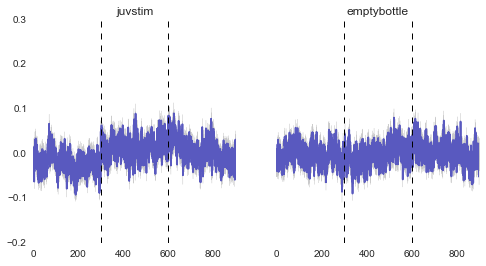

In [34]:
fig, axs = plt.subplots(1,len(conditions),sharey='row', figsize=(4*len(conditions),4))
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    sns.tsplot(data_to_plot, ax=axs[c], color=(0.35,0.35,0.75))
    axs[c].set_xticks(range(0, epoch_limits[-1]+1, 1000))
    axs[c].set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[-1]+1, 1000)])
    axs[c].set_title(condition)
    axs[c].set_ylim([-0.2, 0.3])
    temp = axs[c].get_ylim()
    axs[c].plot([epoch_limits[1], epoch_limits[1]], [temp[0], temp[1]], '--k', linewidth=1)
    axs[c].plot([epoch_limits[2], epoch_limits[2]], [temp[0], temp[1]], '--k', linewidth=1)
#fig.savefig(os.path.join(basedir, '%s_averageresponses.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_averageresponses_allcells.pdf'%group), format='pdf')

Median response of all cells to juvstim = 1.082197e-02
Median response of all cells to empty bottle = -1.488200e-02
Wilcoxon signed rank T (102) = 1556.000000, two-tailed p value = 3.522094e-04


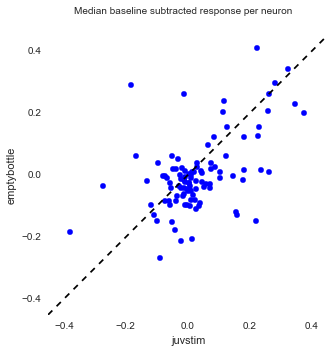

In [18]:
fig, ax = plt.subplots(figsize=(5,5))
x = median_responses[conditions[0]][:,0]; y = median_responses[conditions[1]][:,0]
ax.scatter(x, y, s=30, color='b')
ax.set_xlabel(conditions[0])
ax.set_ylabel(conditions[1])
axlim = 1.1*np.amax(np.abs(np.concatenate((x,y))))
ax.plot([-axlim, axlim], [-axlim, axlim], '--k')
ax.set_xlim([-axlim, axlim])
ax.set_ylim([-axlim, axlim])
fig.suptitle('Median baseline subtracted response per neuron')
#fig.savefig(os.path.join(basedir, '%s_Scatterplot.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_Scatterplot.pdf'%group), format='pdf')

print 'Median response of all cells to juvstim = %e\n\
Median response of all cells to empty bottle = %e\n\
Wilcoxon signed rank T (%d) = %f, two-tailed p value = %e' %(np.median(x), np.median(y), x.size,
                                                        stats.wilcoxon(x, y)[0], stats.wilcoxon(x, y)[1])


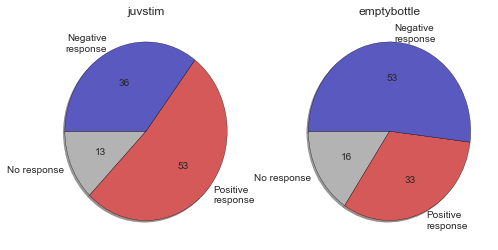

In [19]:
fig, axs = plt.subplots(1,len(conditions),figsize=(4*len(conditions),4))
labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
colors_groups = [(0.7, 0.7,0.7),(0.84, 0.35, 0.35),(0.35,0.35,0.75)]
explode=(0, 0, 0)
for c, condition in enumerate(conditions):
    num_increase = np.sum((median_responses[condition][:,1]<0.05)  & (median_responses[condition][:,0]>0))
    num_decrease = np.sum((median_responses[condition][:,1]<0.05)  & (median_responses[condition][:,0]<0))
    num_nochange = np.sum((median_responses[condition][:,1]>=0.05))
    total = num_increase + num_decrease + num_nochange
    axs[c].pie(np.array([num_nochange, num_increase, num_decrease]), explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * total / 100), pctdistance=0.6, shadow=True, startangle=180, colors=colors_groups)
    axs[c].set_title(condition)
#fig.savefig(os.path.join(basedir, '%s_piechart.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_piechart.pdf'%group), format='pdf')

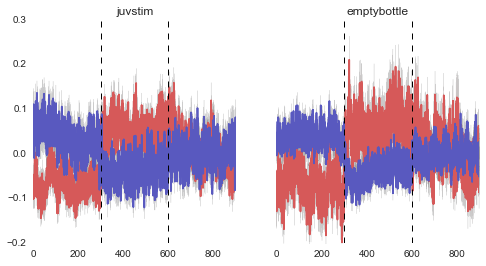

In [20]:
fig, axs = plt.subplots(1,len(conditions),sharey='row', figsize=(4*len(conditions),4))
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    cells_increase = (median_responses[condition][:,1]<0.05)  & (median_responses[condition][:,0]>0)
    sns.tsplot(data_to_plot[cells_increase,:], ax=axs[c], color=(0.84, 0.35, 0.35))
    cells_decrease = (median_responses[condition][:,1]<0.05)  & (median_responses[condition][:,0]<0)
    sns.tsplot(data_to_plot[cells_decrease,:], ax=axs[c], color=(0.35,0.35,0.75))
    axs[c].set_xticks(range(0, epoch_limits[-1]+1, 1000))
    axs[c].set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[-1]+1, 1000)])
    axs[c].set_title(condition)
    axs[c].set_ylim([-0.2, 0.3])
    temp = axs[c].get_ylim()
    axs[c].plot([epoch_limits[1], epoch_limits[1]], [temp[0], temp[1]], '--k', linewidth=1)
    axs[c].plot([epoch_limits[2], epoch_limits[2]], [temp[0], temp[1]], '--k', linewidth=1)
#fig.savefig(os.path.join(basedir, '%s_averageresponses.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_averageresponses.pdf'%group), format='pdf')

6
[ 10  20  17  48   9  46  30  31  45  50  28  43  40  49  21  29   3   7
  39  14  51  22  44  13  27   4  12  16  11  23  19  32  52  26  47  41
   1  25   0  38  15  69   2  24   5 100  58  94  98  96  62  53  68 101
  59  73  37  92  86  97  36   6  60  85  61   8  91  42  90  95  88  56
  99  55  57  18  54  84  33  89  87  72  67  93  35  34  80  76  66  74
  81  64  78  75  65  63  77  83  71  82  79  70]
[ 10  20  30  17  31   9  39  50  46  28  40  29  43  45  48  49  51  14
   0  21  13  52  38  22  44  23  27  32  19   4  26  37  11  12  25   5
   3   2  15  98   8  36   6  24  69  16  18  94  96  53  58  73 100 101
  97  41  85  42  60  91  47  62  68  99  86   7  88  59  92  61  56  95
  84  55  90  34  54  57  87   1  89  67  76  93  71  66  80  35  65  83
  63  82  81  74  64  72  77  78  70  75  79  33]


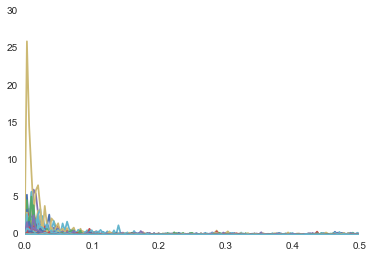

In [12]:
numsamples_fft = epoch_limits[1]-epoch_limits[0]
xf = np.fft.fftfreq(numsamples_fft, d=1.0/framerate) # Frequency axis
freq_cutoff = 0.02
freq_cutoff_index = np.where(xf>=freq_cutoff)[0][0]
print freq_cutoff_index
powerspectra_dict = {}
fig, ax = plt.subplots()
ax.set_xlim([0, 0.5])
for c, condition in enumerate(conditions):
    baselines = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)[:,epoch_limits[0]:epoch_limits[1]]
    power_forneuron = np.nan*np.ones(baselines.shape)
    #power_lowandhighband = np.nan*np.ones((baselines.shape[0], 2))
    for neuron in range(baselines.shape[0]):
        temp = baselines[neuron,:]
        temp = temp-np.mean(temp)
        power_forneuron[neuron, :] = np.abs(np.fft.fft(temp))**2/numsamples_fft
        #power_lowandhighband[neuron, 0] = np.mean(power_forneuron[neuron, :freq_cutoff_index])
        #power_lowandhighband[neuron, 1] = np.mean(power_forneuron[neuron, freq_cutoff_index:numsamples_fft/2])
        if c==0:
            ax.plot(xf[:numsamples_fft/2], power_forneuron[neuron, :numsamples_fft/2])
    #ax.scatter(power_lowandhighband[:,0], power_lowandhighband[:,1])    
    sorted_neurons = np.argsort(np.mean(power_forneuron[:,:numsamples_fft/2], axis=1))
    print sorted_neurons
    powerspectra_dict[condition] = power_forneuron

We calculated the mean power across all frequencies as the mean squared absolute values of the FFT across frequencies and separated them by "high power" and "low power" neurons.

We sorted neurons by their mean power and calculated the difference between two consecutively ranked neurons (Figure b). From this, we approximated the "knee" in the plot (i.e. where the positive tail of the distribution begins) by setting a threshold difference to the median + 2 times the interquartile range of this distribution of power differences.

35


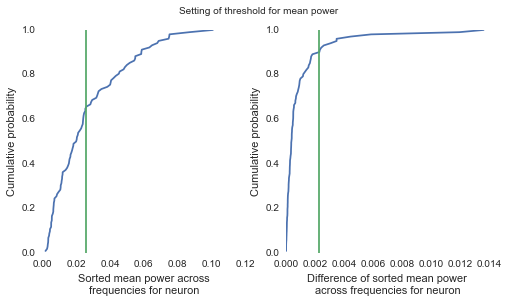

In [21]:
x = np.mean(power_forneuron[:,:numsamples_fft/2], axis=1)
ix = np.argsort(x)
sortx = x[ix]
diffsortx = np.diff(sortx)
fig, axs = plt.subplots(1,2,figsize=(8,4))
ax = axs[1]
CDFplot(diffsortx, ax)
threshold_idx = np.where(diffsortx>(np.median(diffsortx)+2*np.subtract(*np.percentile(diffsortx, [75, 25]))))[0][0]
ax.plot([diffsortx[threshold_idx], diffsortx[threshold_idx]],[0, 1])
ax.set_xlabel('Difference of sorted mean power\nacross frequencies for neuron')
ax.set_ylabel('Cumulative probability')
ax = axs[0]
ax.plot(sortx, ECDF(x)(x)[ix])
ax.plot([sortx[threshold_idx], sortx[threshold_idx]],[0, 1])
ax.set_xlabel('Sorted mean power across\nfrequencies for neuron')
ax.set_ylabel('Cumulative probability')
threshold = sortx[threshold_idx]
print np.sum(np.mean(power_forneuron[:,:numsamples_fft/2], axis=1)>threshold)
fig.suptitle('Setting of threshold for mean power')

#fig.savefig(os.path.join(basedir, '%s_thresholdsetting_basedon_baselinepower.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_thresholdsetting_basedon_baselinepower.pdf'%group), format='pdf')

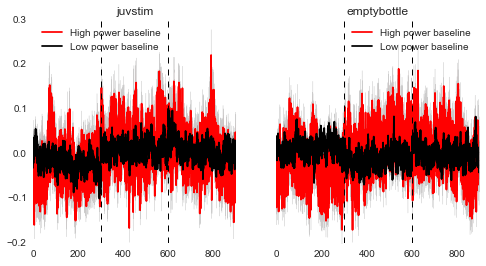

In [29]:
highpower_neurons = (np.mean(power_forneuron[:,:numsamples_fft/2], axis=1)>threshold)
lowpower_neurons = (np.mean(power_forneuron[:,:numsamples_fft/2], axis=1)<=threshold)

fig, axs = plt.subplots(1,len(conditions),sharey='row', figsize=(4*len(conditions),4))
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    sns.tsplot(data_to_plot[highpower_neurons,:], ax=axs[c], color='r', condition='High power baseline')
    sns.tsplot(data_to_plot[lowpower_neurons,:], ax=axs[c], color='k', condition='Low power baseline')
    axs[c].set_xticks(range(0, epoch_limits[-1]+1, 1000))
    axs[c].set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[-1]+1, 1000)])
    axs[c].set_title(condition)
    axs[c].set_ylim([-0.2, 0.3])
    temp = axs[c].get_ylim()
    axs[c].plot([epoch_limits[1], epoch_limits[1]], [temp[0], temp[1]], '--k', linewidth=1)
    axs[c].plot([epoch_limits[2], epoch_limits[2]], [temp[0], temp[1]], '--k', linewidth=1)
#fig.savefig(os.path.join(basedir, '%s_averageresponses_baselinegroups.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_averageresponses_baselinegroups.pdf'%group), format='pdf')

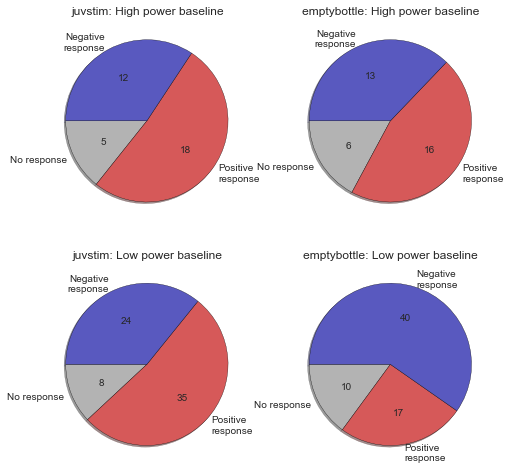

In [23]:
fig, axs = plt.subplots(2,len(conditions),figsize=(4*len(conditions),4*2))
labels = 'No response', 'Positive\nresponse', 'Negative\nresponse'
colors_groups = [(0.7, 0.7,0.7),(0.84, 0.35, 0.35),(0.35,0.35,0.75)]
explode=(0, 0, 0)
for c, condition in enumerate(conditions):
    neuronsofinterest = highpower_neurons
    num_increase = np.sum((median_responses[condition][neuronsofinterest,1]<0.05)  & (median_responses[condition][neuronsofinterest,0]>0))
    num_decrease = np.sum((median_responses[condition][neuronsofinterest,1]<0.05)  & (median_responses[condition][neuronsofinterest,0]<0))
    num_nochange = np.sum((median_responses[condition][neuronsofinterest,1]>=0.05))
    total = np.sum(neuronsofinterest)
    axs[0,c].pie(np.array([num_nochange, num_increase, num_decrease]), explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * total / 100), pctdistance=0.6, shadow=True, startangle=180, colors=colors_groups)
    axs[0,c].set_title(condition+': High power baseline')
    
    neuronsofinterest = lowpower_neurons
    num_increase = np.sum((median_responses[condition][neuronsofinterest,1]<0.05)  & (median_responses[condition][neuronsofinterest,0]>0))
    num_decrease = np.sum((median_responses[condition][neuronsofinterest,1]<0.05)  & (median_responses[condition][neuronsofinterest,0]<0))
    num_nochange = np.sum((median_responses[condition][neuronsofinterest,1]>=0.05))
    total = np.sum(neuronsofinterest)
    axs[1,c].pie(np.array([num_nochange, num_increase, num_decrease]), explode=explode, labels=labels,
                autopct=lambda(p): '{:.0f}'.format(p * total / 100), pctdistance=0.6, shadow=True, startangle=180, colors=colors_groups)
    axs[1,c].set_title(condition+': Low power baseline')
#fig.savefig(os.path.join(basedir, '%s_piechart_baselinepower.eps'%group), format='eps')
fig.savefig(os.path.join(basedir, '%s_piechart_baselinepower.pdf'%group), format='pdf')

Median response of high power cells to juvstim = 2.353293e-02
Median response of high power cells to empty bottle = 1.874465e-02
Wilcoxon signed rank T (35) = 278.000000, two-tailed p value = 5.444960e-01




Median response of low power cells to juvstim = 7.338971e-03
Median response of low power cells to empty bottle = -2.178124e-02
Wilcoxon signed rank T (67) = 490.000000, two-tailed p value = 5.033348e-05


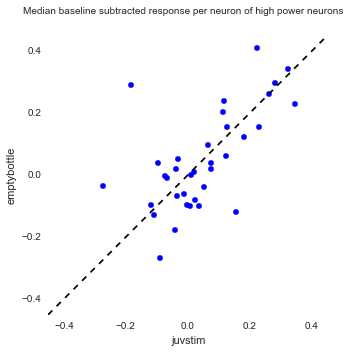

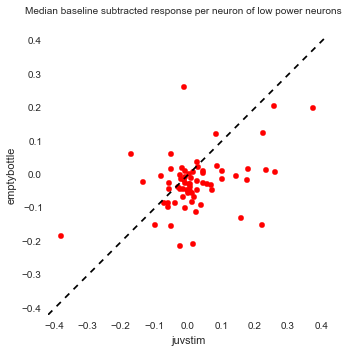

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
neuronsofinterest = highpower_neurons
x = median_responses[conditions[0]][neuronsofinterest,0]; y = median_responses[conditions[1]][neuronsofinterest,0]
ax.scatter(x, y, s=30, color='b')
ax.set_xlabel(conditions[0])
ax.set_ylabel(conditions[1])
axlim = 1.1*np.amax(np.abs(np.concatenate((x,y))))
ax.plot([-axlim, axlim], [-axlim, axlim], '--k')
ax.set_xlim([-axlim, axlim])
ax.set_ylim([-axlim, axlim])
fig.suptitle('Median baseline subtracted response per neuron of high power neurons')
fig.savefig(os.path.join(basedir, '%s_scatterplot_hihpower.pdf'%group), format='pdf')

print 'Median response of high power cells to juvstim = %e\n\
Median response of high power cells to empty bottle = %e\n\
Wilcoxon signed rank T (%d) = %f, two-tailed p value = %e' %(np.median(x), np.median(y), x.size,
                                                        stats.wilcoxon(x, y)[0], stats.wilcoxon(x, y)[1])


fig, ax = plt.subplots(figsize=(5,5))
neuronsofinterest = lowpower_neurons
x = median_responses[conditions[0]][neuronsofinterest,0]; y = median_responses[conditions[1]][neuronsofinterest,0]
ax.scatter(x, y, s=30, color='r')
#sns.jointplot(x,y, color='r', stat_func=None)
ax.set_xlabel(conditions[0])
ax.set_ylabel(conditions[1])
axlim = 1.1*np.amax(np.abs(np.concatenate((x,y))))
ax.plot([-axlim, axlim], [-axlim, axlim], '--k')
ax.set_xlim([-axlim, axlim])
ax.set_ylim([-axlim, axlim])
fig.suptitle('Median baseline subtracted response per neuron of low power neurons')
fig.savefig(os.path.join(basedir, '%s_scatterplot_lowpower.pdf'%group), format='pdf')

print '\n\n\n'

print 'Median response of low power cells to juvstim = %e\n\
Median response of low power cells to empty bottle = %e\n\
Wilcoxon signed rank T (%d) = %f, two-tailed p value = %e' %(np.median(x), np.median(y), x.size,
                                                        stats.wilcoxon(x, y)[0], stats.wilcoxon(x, y)[1])


In [17]:
print sorted(alldata[groups[0]][conditions[0]])
print [alldata[groups[0]][conditions[0]][a].shape[0] for a in sorted(alldata[groups[0]][conditions[0]])]

print 'Low power neurons', np.where(lowpower_neurons)[0]
print 'High power neurons', np.where(highpower_neurons)[0]

['OTPVNlens2p1', 'OTPVNlens2p3', 'OTPVNlens2p4', 'OTPVNlens2p5', 'OTPVNlens2p6', 'OTPVNlens2p7', 'OTPVNlens2p8plane450', 'OTPVNlens2p9']
[23L, 10L, 8L, 7L, 5L, 10L, 22L, 17L]
Low power neurons [  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  58  60  62  68
  69  73  85  86  88  91  94  96  97  98  99 100 101]
High power neurons [ 1 33 34 35 54 55 56 57 59 61 63 64 65 66 67 70 71 72 74 75 76 77 78 79 80
 81 82 83 84 87 89 90 92 93 95]


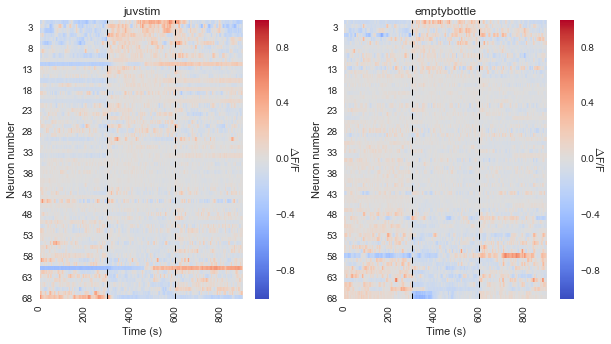

In [27]:
vmax=1
window_size = 30 # for smoothing
sortedneurons=None
fig, axs = plt.subplots(1, len(conditions), figsize=(10,5))
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    neuronsofinterest = lowpower_neurons
    data_to_plot = data_to_plot[neuronsofinterest,:]
    fig, axs[c], sortedneurons = plot_histograms(movingaverage(data_to_plot, window_size=window_size),
                                                 epoch_limits, fig, axs[c], framerate,
                                                 vmin=-vmax, vmax=vmax, sortedneurons=sortedneurons,
                                                 title=condition)
fig.savefig(os.path.join(basedir, '%s_heatmap_smoothedby%d_LOWPOWER.png'%(group, window_size)), format='png')

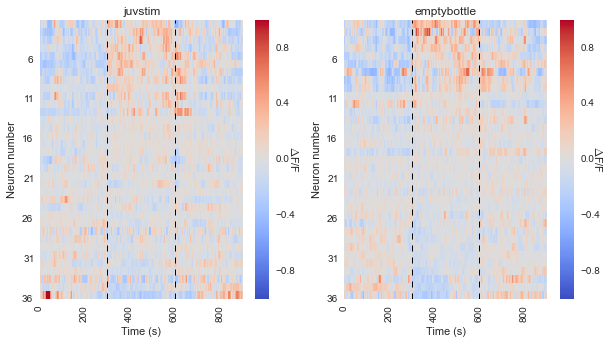

In [28]:
vmax=1
window_size = 30 # for smoothing
sortedneurons=None
fig, axs = plt.subplots(1, len(conditions), figsize=(10,5))
for c, condition in enumerate(conditions):
    data_to_plot = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
    neuronsofinterest = highpower_neurons
    data_to_plot = data_to_plot[neuronsofinterest,:]
    fig, axs[c], sortedneurons = plot_histograms(movingaverage(data_to_plot, window_size=window_size),
                                                 epoch_limits, fig, axs[c], framerate,
                                                 vmin=-vmax, vmax=vmax, sortedneurons=sortedneurons,
                                                 title=condition)
fig.savefig(os.path.join(basedir, '%s_heatmap_smoothedby%d_HIGHPOWER.png'%(group, window_size)), format='png')

# IGNORE FROM BELOW

[10 20 30 17 31  9 39 50 46 28 40 29 43 45 48 49 51 14  0 21 13 52 38 22 44
 23 27 32 19  4 26 37 11 12 25  5  3  2 15  8 36  6 24 16 18 41 42 47  7 34
  1 35 33]


KeyError: 'e'

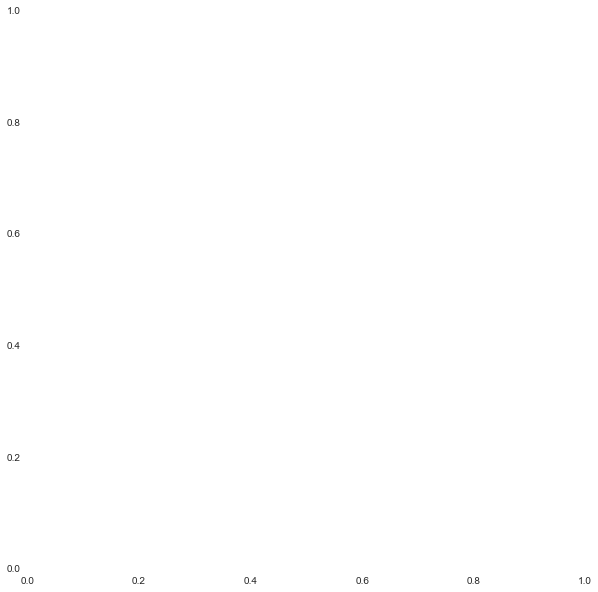

In [45]:
print sorted_neurons
fig, ax = plt.subplots(figsize=(10,10))
condition = condition[0]
#baselines = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)[:,epoch_limits[0]:epoch_limits[1]]
signals = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
data_to_plot = signals
#sns.heatmap(data_to_plot[sorted_neurons,:], ax=ax)
"""ax.set_xticks(range(0, epoch_limits[1]+1, 1000))
ax.set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[1]+1, 1000)])
ax.set_yticks(range(0, baselines.shape[0], 5))
ax.set_yticklabels([str(a+1) for a in range(baselines.shape[0],0, -5)])
"""
fig, ax, sortedneurons = plot_histograms(data_to_plot, epoch_limits, fig, ax, framerate, sort=False,
                                         vmin=-vmax, vmax=vmax, sortedneurons=sorted_neurons,
                                         title=condition)


In [ ]:
print sorted_neurons
fig, ax = plt.subplots(figsize=(10,10))
condition = condition[0]
baselines = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)[:,epoch_limits[0]:epoch_limits[1]]
signals = np.concatenate([alldata[group][condition][a] for a in sorted(alldata[group][condition])], axis=0)
data_to_plot = baselines
sns.heatmap(data_to_plot[sorted_neurons,:], ax=ax)
ax.set_xticks(range(0, epoch_limits[1]+1, 1000))
ax.set_xticklabels([str(int(a/framerate)) for a in range(0, epoch_limits[1]+1, 1000)])
ax.set_yticks(range(0, baselines.shape[0], 5))
ax.set_yticklabels([str(a) for a in range(baselines.shape[0],0, -5)])

In [ ]:
fig.savefig(os.path.join(basedir, 'Heatmap sorted by baseline power.pdf'), format='pdf')
fig.savefig(os.path.join(basedir, 'Heatmap sorted by baseline power.png'), format='png', dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
condition1 = 1
condition2 = 0
x = np.mean(powerspectra_dict[conditions[condition1]][:,:numsamples_fft/2], axis=1)
y = np.mean(powerspectra_dict[conditions[condition2]][:,:numsamples_fft/2], axis=1)
fit_regression_and_plot(x, y, ax, color='b', markersize=70)
ax.set_xlabel('Mean power during baseline of %s'%(conditions[condition1]))
ax.set_ylabel('Mean power during baseline of %s'%(conditions[condition2]))
ax.legend(loc='upper right')
fig.savefig(os.path.join(basedir, 'Correlation between baselines.eps'), format='eps')

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
condition1 = 0
condition2 = 0
fit_regression_and_plot(np.mean(powerspectra_dict[conditions[condition1]][:,:numsamples_fft/2], axis=1),
                        mean_responses[conditions[condition2]], ax, color='b', markersize=70)
ax.set_xlabel('Mean power during baseline of %s'%(conditions[condition1]))
ax.set_ylabel('Mean baseline subtracted response of %s'%(conditions[condition2]))
ax.legend(loc='upper right')
fig.savefig(os.path.join(basedir, 'Correlation between baseline power and response juvstim.eps'), format='eps')